# Example Couplings for experimentally realistic 3jj flux qubits.

## Study of the properties of two example systems composed of two 3jj flux qubits with realistic experimental parameters coupled throught a capacitor or a Josephson junction.

In this notebook we study a example configurations for two identical 3 Josephson junctions flux qubits, using realistic values of the qubit parameters $\alpha$ and $r=E_J/E_C$ extracted from exprimental results. We obtain the coupling strenght, energies and qubit Hamiltonian for the different circuits using single qubits basis and the Schieffer-Wolf transformation (SWT).

For this purpose we use the python archive 'CircuitClass_SWTPauliBasis.py' which defines a python class containing all the necessary tools for building a superconducting circuit, finding its Hamiltonian and performing the SWT (to find a complete description of this class and how do we have to use it to obtain our results go to: 'QubitBasisDefinition.ipynb'). Here, we only load the results obtained using this procedure since the calculation takes a lot of time and has already been performed in a cluster (the steps on how to construct the example circuits defined here and obtain the results can be found in FluxQubitsCapacitiveCoupling_ground1.ipynb and FluxQubitsJJCoupling_ground0.ipynb)

---

In [1]:
#Import libraries
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spl
import scipy.optimize
import scipy.interpolate
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
np.set_printoptions( linewidth=1000 )
import timeit
from matplotlib import pyplot as plt
import csv
np.set_printoptions( linewidth=1000 )
from matplotlib import rcParams, rcParamsDefault
import CircuitClass_SWTPauliBasis as CClass

In [2]:
# Useful functions.
def pauli_recomposition_4x4(P):
    '''Recomposes a 4x4 matrix from its pauli decomposition.
    
    Input:
    P= Pauli coefficients.
    rd= number of decimals to use when rounding a number.
    
    Output:
    A= matrix such that such that A = ΣP[i,j]σ_iσ_j where i,j=0, 1, 2, 3. '''
    
    i  = np.eye(2)  #σ_0     
    σx = np.array([[0, 1], [1, 0]])
    σy = np.array([[0, -1j], [1j, 0]])
    σz = np.array([[1, 0], [0, -1]])
    s = [i, σx, σy, σz] #array containing the matrices.
    labels = ['I', 'σx', 'σy', 'σz'] # useful to print the result.
    
    A=sum(P[o1][o2]*np.kron(O1,O2)
                for o1, O1 in enumerate(s)
                for o2, O2 in enumerate(s))
    
    return A


def zero_if_close(a, tol):
    a.real[abs(a.real) < tol] = 0.0
    a.imag[abs(a.imag) < tol] = 0.0
    return a

def export(fig_title):
    plt.gcf()
    plt.margins(0,0)
    plt.savefig(fig_title, bbox_inches = 'tight', pad_inches = 0)
    
def setlabel(ax, label, loc=2, borderpad=0.6, **kwargs):
    legend = ax.get_legend()
    if legend:
        ax.add_artist(legend)
    line, = ax.plot(np.NaN,np.NaN,color='none',label=label)
    label_legend = ax.legend(handles=[line],loc=loc,handlelength=0,handleheight=0,handletextpad=0,borderaxespad=0,borderpad=borderpad,frameon=False,**kwargs)
    label_legend.remove()
    ax.add_artist(label_legend)
    line.remove()    

In [3]:
#We define a function to load the data.
# Define a function to extract the data from the txt. 
def txt_to_npz(EJ, EC, alpha, beta, nmax, r):

    #Open first.txt to extract the lenghts.
    lines = []                             # Declare an empty list to store lines.
    with open ('r'+str(EJ/EC)+'EJ'+str(EJ)+'alpha'+str(alpha)+'beta'+str(beta)+'nmax'+str(nmax)+'_r'+str(r)+'.dat', 'rt') as txt: # Open .txt for reading text data.
        for line in txt:                # For each line, stored as line.
            lines.append(line)
        
    #Extract the data from lines.
    gamma=lines[1].split() #remember that the first line are the coments so gamma = second line.
    for i in range(len(gamma)): 
        gamma[i]=complex(gamma[i])
        
    P=np.zeros((len(gamma), 4, 4),dtype=complex) #Matrix to store the P_ij values.
    E=np.zeros((len(gamma),7),dtype=complex) #Matrix to store the energies values.
    Eq=np.zeros((len(gamma),4),dtype=complex) #Matrix to store the effective energies values.
    
    
    #Extract the data from lines.
    for r in range(7):
        E_aux= lines[r+2].split() #rows from 2 to 8 give the energies.
        for s in range(len(E_aux)):
            E_aux[s]=complex(E_aux[s])
        E[:,r]=E_aux
        
    P_aux=lines[9].split()
    for s in range(len(P_aux)): 
        P_aux[s]=complex(P_aux[s])
    P[:,0,0]=P_aux
                    
    P_aux=lines[10].split()
    for s in range(len(P_aux)): 
        P_aux[s]=complex(P_aux[s])
    P[:,1,1]=P_aux
                    
    P_aux=lines[11].split()
    for s in range(len(P_aux)): 
        P_aux[s]=complex(P_aux[s])
    P[:,2,2]=P_aux
                    
    P_aux=lines[12].split()
    for s in range(len(P_aux)): 
        P_aux[s]=complex(P_aux[s])
    P[:,3,3]=P_aux
                    
    P_aux=lines[13].split()
    for s in range(len(P_aux)): 
        P_aux[s]=complex(P_aux[s])
    P[:,0,1]=P_aux
                    
    P_aux=lines[14].split()
    for s in range(len(P_aux)): 
        P_aux[s]=complex(P_aux[s])
    P[:,1,0]=P_aux
                    
    P_aux=lines[15].split()
    for s in range(len(P_aux)): 
        P_aux[s]=-complex(P_aux[s])
    P[:,0,2]=P_aux
                    
    P_aux=lines[16].split()
    for s in range(len(P_aux)): 
        P_aux[s]=-complex(P_aux[s])
    P[:,2,0]=P_aux
                    
    P_aux=lines[17].split()
    for s in range(len(P_aux)): 
        P_aux[s]=-complex(P_aux[s])
    P[:,0,3]=P_aux
                    
    P_aux=lines[18].split()
    for s in range(len(P_aux)): 
        P_aux[s]=-complex(P_aux[s])
    P[:,3,0]=P_aux
                    
    P_aux=lines[19].split()
    for s in range(len(P_aux)): 
        P_aux[s]=-complex(P_aux[s])
    P[:,1,2]=P_aux
                    
    P_aux=lines[20].split()
    for s in range(len(P_aux)): 
        P_aux[s]=-complex(P_aux[s])
    P[:,2,1]=P_aux
                    
    P_aux=lines[21].split()
    for s in range(len(P_aux)): 
        P_aux[s]=-complex(P_aux[s])
    P[:,1,3]=P_aux
                    
    P_aux=lines[22].split()
    for s in range(len(P_aux)): 
        P_aux[s]=-complex(P_aux[s])
    P[:,3,1]=P_aux
                    
    P_aux=lines[23].split()
    for s in range(len(P_aux)): 
        P_aux[s]=complex(P_aux[s])
    P[:,2,3]=P_aux
                    
    P_aux=lines[24].split()
    for s in range(len(P_aux)): 
        P_aux[s]=complex(P_aux[s])
    P[:,3,2]=P_aux
                    
    for s in range(len(gamma)):
        Eq[s,:],_=np.linalg.eigh(pauli_recomposition_4x4(P[s,:,:]))
    
    E=np.real_if_close(E)
    Eq=np.real_if_close(Eq)
    P=np.real_if_close(zero_if_close(P,1e-10))
    gamma=np.real_if_close(gamma)
    
    return gamma, E, Eq, P

---

### Example Capacitive Coupling Circuit.

Here we analyze the results obtained for realizable 3 Josephson junction qubits for the circuit example:
<img src="CC_g0c1.png"
     style=" width: 500px;"/>

In [4]:
#Circuit definition.
#Capacitor coupling circuit.
def Circuit_CapacitiveCoupling(gamma, alpha, nmax, flux1, flux2, EC, EJ, pert1=0, pert2=0, beta=0):
    # This ensures alpha has at least two elements
    alpha1, alpha2 = alpha * np.ones(2)
    C=CClass.Circuit(6, nmax=nmax)
    # Add capacitances and junctions for qubit L1 y L2. 
    C.add_capacitance(1.0, 0, 1)
    C.add_capacitance(1.0, 0, 2)
    C.add_capacitance(alpha1+beta, 1, 2) 
    C.add_junction(1, 1, +1, 0, -1)
    C.add_junction(1, 2, -1, 0, +1)
    C.add_junction(alpha1*(1+pert1), 2, -1, 1, +1,-flux1)
    C.add_capacitance(1.0, 3, 4)
    C.add_capacitance(1.0, 3, 5)
    C.add_capacitance(alpha2+beta, 4, 5)
    C.add_junction(1, 4, +1, 3, -1)
    C.add_junction(1, 5, -1, 3, +1)
    C.add_junction(alpha2*(1+pert2), 5, -1, 4, +1,-flux2)
    #Coupling.
    if gamma:
        C.add_capacitance(gamma, 2, 4)
    #Ground.
    return C.set_ground([0,3])

We begin with the 3jj qubit realized by Caspar H. van der Wal et al in [https://science.sciencemag.org/content/290/5492/773]. For this qubit $\alpha=0.82$, $E_C=5.86 GHz$ and $r=38$ ($E_J=223.06GHz$).

In [5]:
#Circuit parameters.
#Set parameters.
flux1=0.5*2*np.pi
flux2=0.5*2*np.pi
EJ=223.06
nmax=15
n0=10
rd=10
e=1e-4
β=0
α=0.82
EC=EJ/38
#γ given by the .txt.

#Load the results.
γ1, E1, Eq1, P1 = txt_to_npz(EJ, EC, α, β, nmax, 3) #The last parameter gives the coupling (r=3-> capacitive coupling)

Text(0.5, 1.0, 'Coupling Strenghts/Gap')

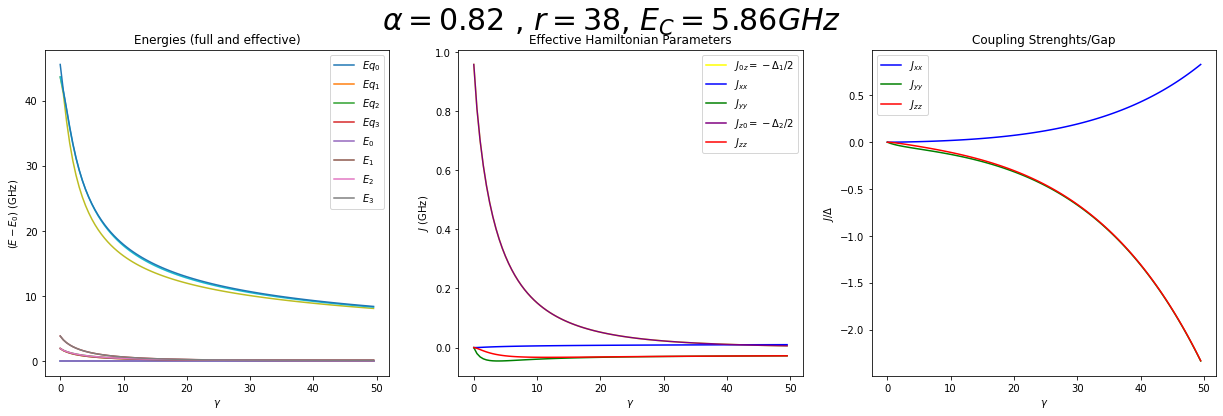

In [6]:
#Plot the results: full system and effective energies, effective Hamiltonian parameters and  effective -hamiltonian constanst/gap.
fig, (ax1, ax2, ax3)= plt.subplots(ncols=3, nrows=1, figsize=(21, 6))
fig.suptitle('$α=0.82$ , $r=38$, $E_C=5.86 GHz$', fontsize=30)

#Energies
ax1.plot(γ1[:], Eq1[:,:] - Eq1[:, 4*[0]], γ1[:], E1[:,:]-E1[:,7*[0]], label='Inline label')
ax1.legend(('$Eq_0$','$Eq_1$','$Eq_2$','$Eq_3$','$E_0$','$E_1$','$E_2$','$E_3$'))
ax1.set_xlabel('$\gamma$')
ax1.set_ylabel('$(E-E_0)$ (GHz)') 
ax1.set_title('Energies (full and effective)')

#Constants.
colors=[['gray', 'gray', 'gray', 'yellow'],['gray', 'blue', 'gray', 'gray'],['gray', 'gray', 'green', 'gray'],['purple', 'gray', 'gray', 'red']]
labels = [['$J_{00}$', '$J_{0x}$','$J_{0y}=-\epsilon_1/2$','$J_{0z}=-\Delta_1/2$'],['$J_{x0}$', '$J_{xx}$','$J_{xy}$','$J_{xz}$'],['$J_{y0}=-\epsilon_2/2$', '$J_{yx}$','$J_{yy}$','$J_{yz}$'], ['$J_{z0}=-\Delta_2/2$', '$J_{zx}$','$J_{zy}$','$J_{zz}$']] # useful to print the legend.
for l in range(4):
    for n in range(4):
        if n!=0 or l!=0:
            if np.any(P1[:,l,n]!=0):
                label=labels[l][n]
                ax2.plot(γ1[:], P1[:,l,n],label = label, c=colors[l][n])
ax2.legend()
ax2.set_xlabel('$\gamma$')
ax2.set_ylabel('$J$ (GHz)') 
ax2.set_title('Effective Hamiltonian Parameters')

#Ratios.
for l in range(4):
    for n in range(4):
        if n!=0 and l!=0:
            if np.any(P1[:,l,n]!=0):
                label=labels[l][n]
                ax3.plot(γ1[:], P1[:,l,n]/(2*P1[:,0,3]),label = label, c = colors[l][n])
ax3.legend()
ax3.set_xlabel('$\gamma$')
ax3.set_ylabel('$J/\Delta$') 
ax3.set_title('Coupling Strenghts/Gap')

For the 3jj qubit realized by Chiorescu et al in [https://science.sciencemag.org/content/299/5614/1869]: $\alpha=0.8$, $E_C=7.4 GHz$ and $r=35$ ($E_J=259.0GHz$).

In [7]:
#Circuit parameters.
#Set parameters.
flux1=0.5*2*np.pi
flux2=0.5*2*np.pi
EJ=259.0
nmax=15
n0=10
rd=10
e=1e-4
β=0
α=0.8
EC=EJ/35
#γ given by the .txt.

#Load the results.
γ2, E2, Eq2, P2 = txt_to_npz(EJ, EC, α, β, nmax, 3) #The last parameter gives the coupling (r=3-> capacitive coupling)

Text(0.5, 1.0, 'Coupling Strenghts/Gap')

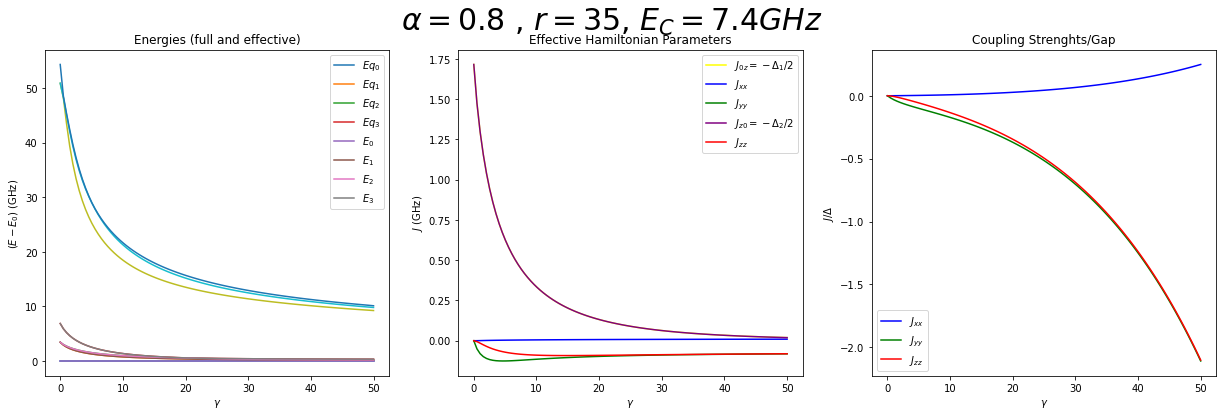

In [8]:
#Plot the results: full system and effective energies, effective Hamiltonian parameters and  effective -hamiltonian constanst/gap.
fig, (ax1, ax2, ax3)= plt.subplots(ncols=3, nrows=1, figsize=(21, 6))
fig.suptitle('$α=0.8$ , $r=35$, $E_C=7.4 GHz$', fontsize=30)

#Energies
ax1.plot(γ2[:], Eq2[:,:] - Eq2[:, 4*[0]], γ2[:], E2[:,:]-E2[:,7*[0]], label='Inline label')
ax1.legend(('$Eq_0$','$Eq_1$','$Eq_2$','$Eq_3$','$E_0$','$E_1$','$E_2$','$E_3$'))
ax1.set_xlabel('$\gamma$')
ax1.set_ylabel('$(E-E_0)$ (GHz)') 
ax1.set_title('Energies (full and effective)')

#Constants.
colors=[['gray', 'gray', 'gray', 'yellow'],['gray', 'blue', 'gray', 'gray'],['gray', 'gray', 'green', 'gray'],['purple', 'gray', 'gray', 'red']]
labels = [['$J_{00}$', '$J_{0x}$','$J_{0y}=-\epsilon_1/2$','$J_{0z}=-\Delta_1/2$'],['$J_{x0}$', '$J_{xx}$','$J_{xy}$','$J_{xz}$'],['$J_{y0}=-\epsilon_2/2$', '$J_{yx}$','$J_{yy}$','$J_{yz}$'], ['$J_{z0}=-\Delta_2/2$', '$J_{zx}$','$J_{zy}$','$J_{zz}$']] # useful to print the legend.
for l in range(4):
    for n in range(4):
        if n!=0 or l!=0:
            if np.any(P2[:,l,n]!=0):
                label=labels[l][n]
                ax2.plot(γ2[:], P2[:,l,n],label = label, c=colors[l][n])
ax2.legend()
ax2.set_xlabel('$\gamma$')
ax2.set_ylabel('$J$ (GHz)') 
ax2.set_title('Effective Hamiltonian Parameters')

#Ratios.
for l in range(4):
    for n in range(4):
        if n!=0 and l!=0:
            if np.any(P2[:,l,n]!=0):
                label=labels[l][n]
                ax3.plot(γ2[:], P2[:,l,n]/(2*P2[:,0,3]),label = label, c = colors[l][n])
ax3.legend()
ax3.set_xlabel('$\gamma$')
ax3.set_ylabel('$J/\Delta$') 
ax3.set_title('Coupling Strenghts/Gap')

And $\alpha=0.8$, $E_C=7.46 GHz$ and $r=35$ ($E_J=261.1GHz$).

In [9]:
#Circuit parameters.
#Set parameters.
flux1=0.5*2*np.pi
flux2=0.5*2*np.pi
EJ=261.1
nmax=15
n0=10
rd=10
e=1e-4
β=0
α=0.8
EC=EJ/35
#γ given by the .txt.

#Load the results.
γ3, E3, Eq3, P3 = txt_to_npz(EJ, EC, α, β, nmax, 3) #The last parameter gives the coupling (r=3-> capacitive coupling)

Text(0.5, 1.0, 'Coupling Strenghts/Gap')

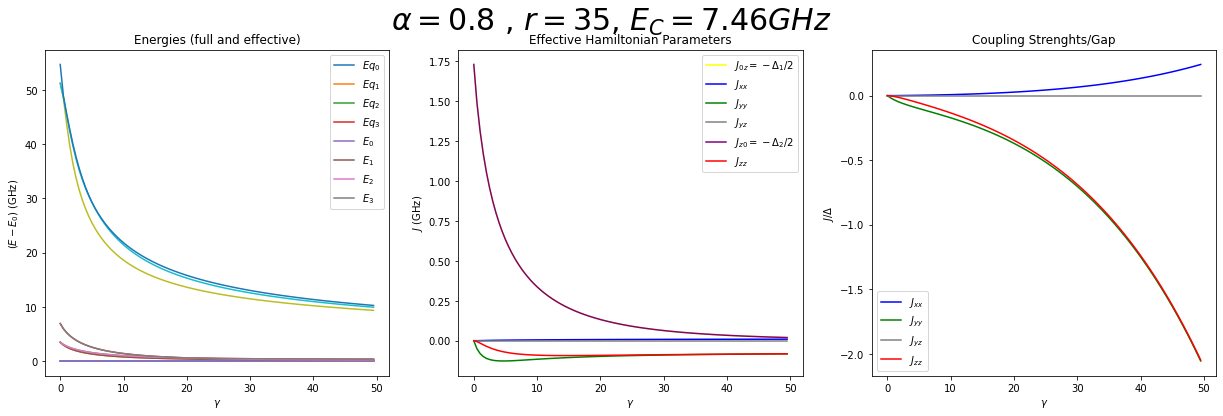

In [10]:
#Plot the results: full system and effective energies, effective Hamiltonian parameters and  effective -hamiltonian constanst/gap.
fig, (ax1, ax2, ax3)= plt.subplots(ncols=3, nrows=1, figsize=(21, 6))
fig.suptitle('$α=0.8$ , $r=35$, $E_C=7.46 GHz$', fontsize=30)

#Energies
ax1.plot(γ3[:], Eq3[:,:] - Eq3[:, 4*[0]], γ3[:], E3[:,:]-E3[:,7*[0]], label='Inline label')
ax1.legend(('$Eq_0$','$Eq_1$','$Eq_2$','$Eq_3$','$E_0$','$E_1$','$E_2$','$E_3$'))
ax1.set_xlabel('$\gamma$')
ax1.set_ylabel('$(E-E_0)$ (GHz)') 
ax1.set_title('Energies (full and effective)')

#Constants.
colors=[['gray', 'gray', 'gray', 'yellow'],['gray', 'blue', 'gray', 'gray'],['gray', 'gray', 'green', 'gray'],['purple', 'gray', 'gray', 'red']]
labels = [['$J_{00}$', '$J_{0x}$','$J_{0y}=-\epsilon_1/2$','$J_{0z}=-\Delta_1/2$'],['$J_{x0}$', '$J_{xx}$','$J_{xy}$','$J_{xz}$'],['$J_{y0}=-\epsilon_2/2$', '$J_{yx}$','$J_{yy}$','$J_{yz}$'], ['$J_{z0}=-\Delta_2/2$', '$J_{zx}$','$J_{zy}$','$J_{zz}$']] # useful to print the legend.
for l in range(4):
    for n in range(4):
        if n!=0 or l!=0:
            if np.any(P3[:,l,n]!=0):
                label=labels[l][n]
                ax2.plot(γ3[:], P3[:,l,n],label = label, c=colors[l][n])
ax2.legend()
ax2.set_xlabel('$\gamma$')
ax2.set_ylabel('$J$ (GHz)') 
ax2.set_title('Effective Hamiltonian Parameters')

#Ratios.
for l in range(4):
    for n in range(4):
        if n!=0 and l!=0:
            if np.any(P3[:,l,n]!=0):
                label=labels[l][n]
                ax3.plot(γ3[:], P3[:,l,n]/(2*P3[:,0,3]),label = label, c = colors[l][n])
ax3.legend()
ax3.set_xlabel('$\gamma$')
ax3.set_ylabel('$J/\Delta$') 
ax3.set_title('Coupling Strenghts/Gap')

---  
### Optimal qubit parameters

Now we try to improve our results by modifying the qubit parameters in a way in which they keep on being realistic (we keep the ratios between energies and change the parameter $\alpha$ which only depends on the area of the capacitor).

We take the 3jj qubit realized by Chiorescu et al and change $\alpha$ to 0.7. As we have seen in the previous studies this will allow us to obtain bigger interactions and energy gaps, making these quantities useful experimentally and  easy to measure.


In [11]:
#Circuit parameters.
#Set parameters.
flux1=0.5*2*np.pi
flux2=0.5*2*np.pi
EJ=259.0
nmax=15
n0=10
rd=10
e=1e-4
β=0
α=0.7
EC=EJ/35
#γ given by the .txt.

#Load the results.
γ20, E20, Eq20, P20 = txt_to_npz(EJ, EC, α, β, nmax, 3) #The last parameter gives the coupling (r=3-> capacitive coupling)

Text(0.5, 1.0, 'Coupling Strenghts/Gap')

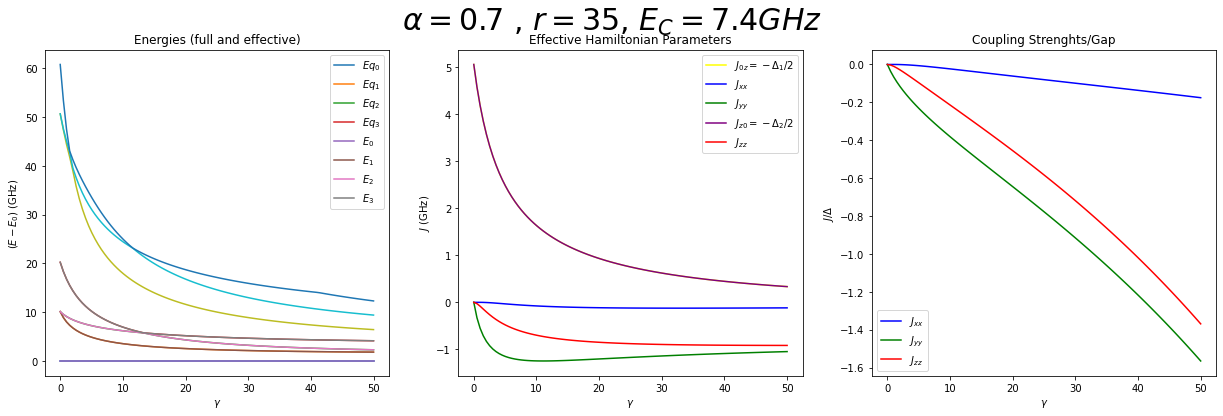

In [12]:
#Plot the results: full system and effective energies, effective Hamiltonian parameters and  effective -hamiltonian constanst/gap.
fig, (ax1, ax2, ax3)= plt.subplots(ncols=3, nrows=1, figsize=(21, 6))
fig.suptitle('$α=0.7$ , $r=35$, $E_C=7.4 GHz$', fontsize=30)

#Energies
ax1.plot(γ20[:], Eq20[:,:] - Eq20[:, 4*[0]], γ20[:], E20[:,:]-E20[:,7*[0]], label='Inline label')
ax1.legend(('$Eq_0$','$Eq_1$','$Eq_2$','$Eq_3$','$E_0$','$E_1$','$E_2$','$E_3$'))
ax1.set_xlabel('$\gamma$')
ax1.set_ylabel('$(E-E_0)$ (GHz)') 
ax1.set_title('Energies (full and effective)')

#Constants.
colors=[['gray', 'gray', 'gray', 'yellow'],['gray', 'blue', 'gray', 'gray'],['gray', 'gray', 'green', 'gray'],['purple', 'gray', 'gray', 'red']]
labels = [['$J_{00}$', '$J_{0x}$','$J_{0y}=-\epsilon_1/2$','$J_{0z}=-\Delta_1/2$'],['$J_{x0}$', '$J_{xx}$','$J_{xy}$','$J_{xz}$'],['$J_{y0}=-\epsilon_2/2$', '$J_{yx}$','$J_{yy}$','$J_{yz}$'], ['$J_{z0}=-\Delta_2/2$', '$J_{zx}$','$J_{zy}$','$J_{zz}$']] # useful to print the legend.
for l in range(4):
    for n in range(4):
        if n!=0 or l!=0:
            if np.any(P20[:,l,n]!=0):
                label=labels[l][n]
                ax2.plot(γ20[:], P20[:,l,n],label = label, c=colors[l][n])
ax2.legend()
ax2.set_xlabel('$\gamma$')
ax2.set_ylabel('$J$ (GHz)') 
ax2.set_title('Effective Hamiltonian Parameters')

#Ratios.
for l in range(4):
    for n in range(4):
        if n!=0 and l!=0:
            if np.any(P20[:,l,n]!=0):
                label=labels[l][n]
                ax3.plot(γ20[:], P20[:,l,n]/(2*P20[:,0,3]),label = label, c = colors[l][n])
ax3.legend()
ax3.set_xlabel('$\gamma$')
ax3.set_ylabel('$J/\Delta$') 
ax3.set_title('Coupling Strenghts/Gap')

In [13]:
#Circuit parameters.
#Set parameters.
flux1=0.5*2*np.pi
flux2=0.5*2*np.pi
EJ=261.1
nmax=15
n0=10
rd=10
e=1e-4
β=0
α=0.7
EC=EJ/35
#γ given by the .txt.

#Load the results.
γ30, E30, Eq30, P30 = txt_to_npz(EJ, EC, α, β, nmax, 3) #The last parameter gives the coupling (r=3-> capacitive coupling)

Text(0.5, 1.0, 'Coupling Strenghts/Gap')

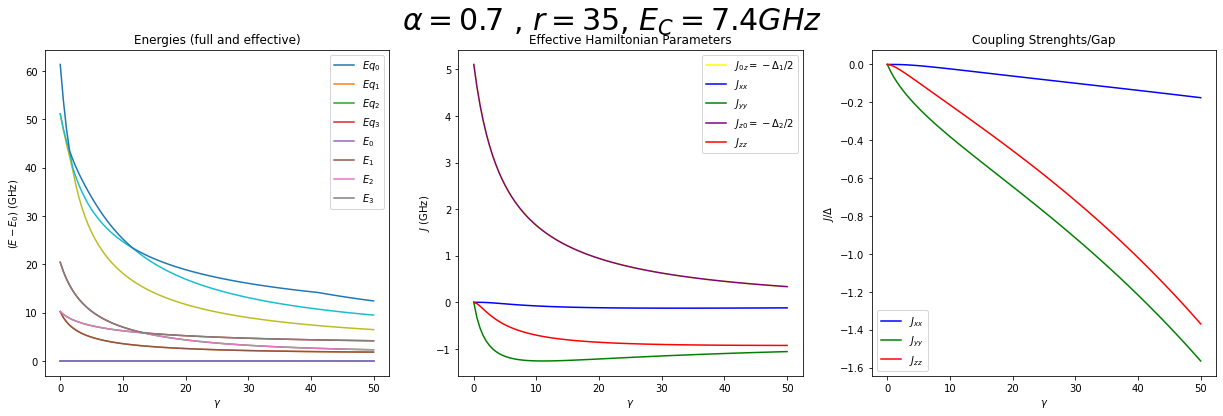

In [14]:
#Plot the results: full system and effective energies, effective Hamiltonian parameters and  effective -hamiltonian constanst/gap.
fig, (ax1, ax2, ax3)= plt.subplots(ncols=3, nrows=1, figsize=(21, 6))
fig.suptitle('$α=0.7$ , $r=35$, $E_C=7.4 GHz$', fontsize=30)

#Energies
ax1.plot(γ30[:], Eq30[:,:] - Eq30[:, 4*[0]], γ30[:], E30[:,:]-E30[:,7*[0]], label='Inline label')
ax1.legend(('$Eq_0$','$Eq_1$','$Eq_2$','$Eq_3$','$E_0$','$E_1$','$E_2$','$E_3$'))
ax1.set_xlabel('$\gamma$')
ax1.set_ylabel('$(E-E_0)$ (GHz)') 
ax1.set_title('Energies (full and effective)')

#Constants.
colors=[['gray', 'gray', 'gray', 'yellow'],['gray', 'blue', 'gray', 'gray'],['gray', 'gray', 'green', 'gray'],['purple', 'gray', 'gray', 'red']]
labels = [['$J_{00}$', '$J_{0x}$','$J_{0y}=-\epsilon_1/2$','$J_{0z}=-\Delta_1/2$'],['$J_{x0}$', '$J_{xx}$','$J_{xy}$','$J_{xz}$'],['$J_{y0}=-\epsilon_2/2$', '$J_{yx}$','$J_{yy}$','$J_{yz}$'], ['$J_{z0}=-\Delta_2/2$', '$J_{zx}$','$J_{zy}$','$J_{zz}$']] # useful to print the legend.
for l in range(4):
    for n in range(4):
        if n!=0 or l!=0:
            if np.any(P30[:,l,n]!=0):
                label=labels[l][n]
                ax2.plot(γ30[:], P30[:,l,n],label = label, c=colors[l][n])
ax2.legend()
ax2.set_xlabel('$\gamma$')
ax2.set_ylabel('$J$ (GHz)') 
ax2.set_title('Effective Hamiltonian Parameters')

#Ratios.
for l in range(4):
    for n in range(4):
        if n!=0 and l!=0:
            if np.any(P30[:,l,n]!=0):
                label=labels[l][n]
                ax3.plot(γ30[:], P30[:,l,n]/(2*P30[:,0,3]),label = label, c = colors[l][n])
ax3.legend()
ax3.set_xlabel('$\gamma$')
ax3.set_ylabel('$J/\Delta$') 
ax3.set_title('Coupling Strenghts/Gap')

---

### Example Josephson junction Coupling Circuit.

Here we analyze the results obtained for realizable 3 Josephson junction qubits for the circuit example:
<img src="JJC_g1c1.png"
     style=" width: 500px;"/>
     
Including this time the capacitor that always accompanies the junction ($\gamma C$) in experiments.

In [15]:
##Circuit definition.
#JJ+capacitor coupling circuit.
def Circuit_CapacitiveJJCoupling(gamma, alpha, nmax, flux1, flux2, EC, EJ, pert1=0, pert2=0, beta=0):
    # This ensures alpha has at least two elements
    alpha1, alpha2 = alpha * np.ones(2)
    C=CClass.Circuit(6, nmax=nmax)
    # Add capacitances and junctions for qubit L1 y L2. 
    C.add_capacitance(1.0, 0, 1)
    C.add_capacitance(1.0, 0, 2)
    C.add_capacitance(alpha1+beta, 1, 2) 
    C.add_junction(1, 1, +1, 0, -1)
    C.add_junction(1, 2, -1, 0, +1)
    C.add_junction(alpha1*(1+pert1), 2, -1, 1, +1,-flux1)
    C.add_capacitance(1.0, 3, 4)
    C.add_capacitance(1.0, 3, 5)
    C.add_capacitance(alpha2+beta, 4, 5)
    C.add_junction(1, 4, +1, 3, -1)
    C.add_junction(1, 5, -1, 3, +1)
    C.add_junction(alpha2*(1+pert2), 5, -1, 4, +1,-flux2)
    #Coupling.
    if gamma:
        C.add_junction(gamma,2, -1, 4, 1)
        C.add_capacitance(gamma, 2, 4)
    #Ground.
    return C.set_ground([1,5])

Once again, we begin with a 3jj qubit realized by Caspar H. van der Wal et al in [https://science.sciencemag.org/content/290/5492/773]. For this qubit $\alpha=0.82$, $E_C=5,86 GHz$ and $r=38$ ($E_J=223.06GHz$).

In [16]:
#Circuit parameters.
#Set parameters.
flux1=0.5*2*np.pi
flux2=0.5*2*np.pi
EJ=223.06
nmax=15
n0=10
rd=10
e=1e-4
β=0
α=0.82
EC=EJ/38
#γ given by the .txt.

#Load the results.
γ4, E4, Eq4, P4 = txt_to_npz(EJ, EC, α, β, nmax, 5) #The last parameter gives the coupling (r=4-> capacitive+jj coupling)

Text(0.5, 1.0, 'Coupling Strenghts/Gap')

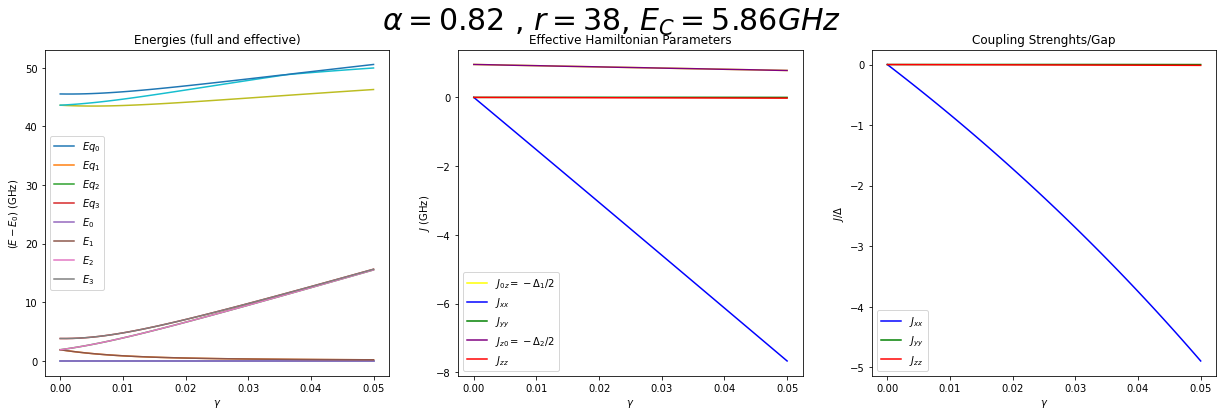

In [17]:
#Plot the results: full system and effective energies, effective Hamiltonian parameters and  effective -hamiltonian constanst/gap.
fig, (ax1, ax2, ax3)= plt.subplots(ncols=3, nrows=1, figsize=(21, 6))
fig.suptitle('$α=0.82$ , $r=38$, $E_C=5.86 GHz$', fontsize=30)

#Energies
ax1.plot(γ4, Eq4 - Eq4[:, 4*[0]], γ4, E4-E4[:,7*[0]], label='Inline label')
ax1.legend(('$Eq_0$','$Eq_1$','$Eq_2$','$Eq_3$','$E_0$','$E_1$','$E_2$','$E_3$'))
ax1.set_xlabel('$\gamma$')
ax1.set_ylabel('$(E-E_0)$ (GHz)') 
ax1.set_title('Energies (full and effective)')

#Constants.
colors=[['gray', 'gray', 'gray', 'yellow'],['gray', 'blue', 'gray', 'gray'],['gray', 'gray', 'green', 'gray'],['purple', 'gray', 'gray', 'red']]
labels = [['$J_{00}$', '$J_{0x}$','$J_{0y}=-\epsilon_1/2$','$J_{0z}=-\Delta_1/2$'],['$J_{x0}$', '$J_{xx}$','$J_{xy}$','$J_{xz}$'],['$J_{y0}=-\epsilon_2/2$', '$J_{yx}$','$J_{yy}$','$J_{yz}$'], ['$J_{z0}=-\Delta_2/2$', '$J_{zx}$','$J_{zy}$','$J_{zz}$']] # useful to print the legend.
for l in range(4):
    for n in range(4):
        if n!=0 or l!=0:
            if np.any(P4[:,l,n]!=0):
                label=labels[l][n]
                ax2.plot(γ4, P4[:,l,n],label = label, c=colors[l][n])
ax2.legend()
ax2.set_xlabel('$\gamma$')
ax2.set_ylabel('$J$ (GHz)') 
ax2.set_title('Effective Hamiltonian Parameters')

#Ratios.
for l in range(4):
    for n in range(4):
        if n!=0 and l!=0:
            if np.any(P4[:,l,n]!=0):
                label=labels[l][n]
                ax3.plot(γ4, P4[:,l,n]/(2*P4[:,0,3]),label = label, c = colors[l][n])
ax3.legend()
ax3.set_xlabel('$\gamma$')
ax3.set_ylabel('$J/\Delta$') 
ax3.set_title('Coupling Strenghts/Gap')

For the 3jj qubit realized by Chiorescu et al in [https://science.sciencemag.org/content/299/5614/1869]: $\alpha=0.8$, $E_C=7.4 GHz$ and $r=35$ ($E_J=259.0GHz$).

In [18]:
#Circuit parameters.
#Set parameters.
flux1=0.5*2*np.pi
flux2=0.5*2*np.pi
EJ=259.0
nmax=15
n0=10
rd=10
e=1e-4
β=0
α=0.8
EC=EJ/35
#γ given by the .txt.

#Load the results.
γ5,E5, Eq5, P5 = txt_to_npz(EJ, EC, α, β, nmax, 5) #The last parameter gives the coupling (r=4-> jj+capacitive coupling)

Text(0.5, 1.0, 'Coupling Strenghts/Gap')

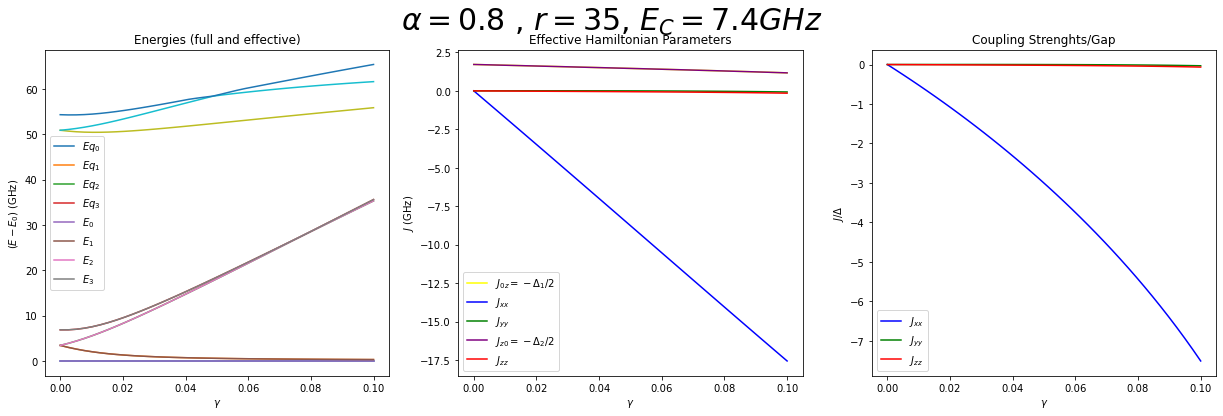

In [19]:
#Plot the results: full system and effective energies, effective Hamiltonian parameters and  effective -hamiltonian constanst/gap.
fig, (ax1, ax2, ax3)= plt.subplots(ncols=3, nrows=1, figsize=(21, 6))
fig.suptitle('$α=0.8$ , $r=35$, $E_C=7.4 GHz$', fontsize=30)

#Energies
ax1.plot(γ5, Eq5 - Eq5[:, 4*[0]], γ5, E5-E5[:,7*[0]], label='Inline label')
ax1.legend(('$Eq_0$','$Eq_1$','$Eq_2$','$Eq_3$','$E_0$','$E_1$','$E_2$','$E_3$'))
ax1.set_xlabel('$\gamma$')
ax1.set_ylabel('$(E-E_0)$ (GHz)') 
ax1.set_title('Energies (full and effective)')

#Constants.
colors=[['gray', 'gray', 'gray', 'yellow'],['gray', 'blue', 'gray', 'gray'],['gray', 'gray', 'green', 'gray'],['purple', 'gray', 'gray', 'red']]
labels = [['$J_{00}$', '$J_{0x}$','$J_{0y}=-\epsilon_1/2$','$J_{0z}=-\Delta_1/2$'],['$J_{x0}$', '$J_{xx}$','$J_{xy}$','$J_{xz}$'],['$J_{y0}=-\epsilon_2/2$', '$J_{yx}$','$J_{yy}$','$J_{yz}$'], ['$J_{z0}=-\Delta_2/2$', '$J_{zx}$','$J_{zy}$','$J_{zz}$']] # useful to print the legend.
for l in range(4):
    for n in range(4):
        if n!=0 or l!=0:
            if np.any(P5[:,l,n]!=0):
                label=labels[l][n]
                ax2.plot(γ5, P5[:,l,n],label = label, c=colors[l][n])
ax2.legend()
ax2.set_xlabel('$\gamma$')
ax2.set_ylabel('$J$ (GHz)') 
ax2.set_title('Effective Hamiltonian Parameters')

#Ratios.
for l in range(4):
    for n in range(4):
        if n!=0 and l!=0:
            if np.any(P5[:,l,n]!=0):
                label=labels[l][n]
                ax3.plot(γ5, P5[:,l,n]/(2*P5[:,0,3]),label = label, c = colors[l][n])
ax3.legend()
ax3.set_xlabel('$\gamma$')
ax3.set_ylabel('$J/\Delta$') 
ax3.set_title('Coupling Strenghts/Gap')

And $\alpha=0.8$, $E_C=7.46 GHz$ and $r=35$ ($E_J=261.1GHz$).

In [20]:
#Circuit parameters.
#Set parameters.
flux1=0.5*2*np.pi
flux2=0.5*2*np.pi
EJ=261.1
nmax=15
n0=10
rd=10
e=1e-4
β=0
α=0.8
EC=EJ/35
#γ given by the .txt.

#Load the results.
γ6,E6, Eq6, P6 = txt_to_npz(EJ, EC, α, β, nmax, 5) #The last parameter gives the coupling (r=4-> jj+capacitive coupling)

Text(0.5, 1.0, 'Coupling Strenghts/Gap')

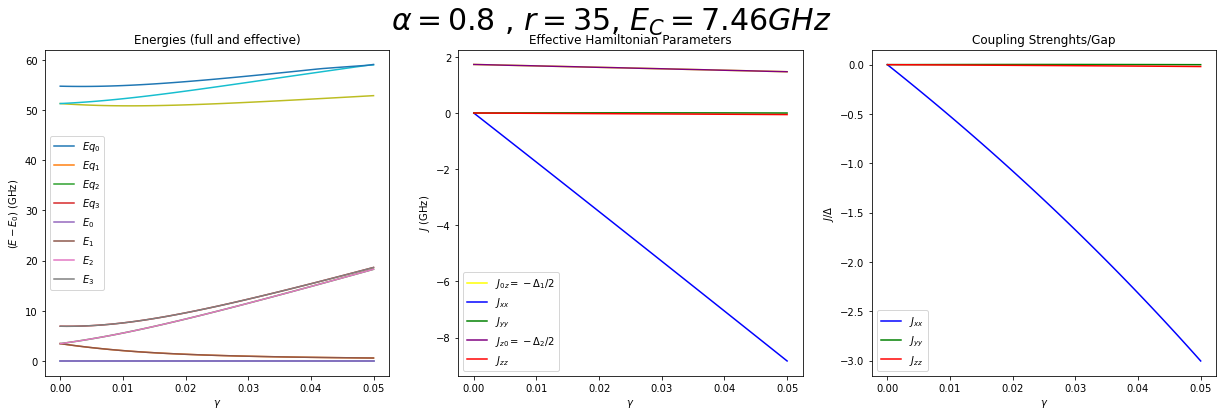

In [21]:
#Plot the results: full system and effective energies, effective Hamiltonian parameters and  effective -hamiltonian constanst/gap.
fig, (ax1, ax2, ax3)= plt.subplots(ncols=3, nrows=1, figsize=(21, 6))
fig.suptitle('$α=0.8$ , $r=35$, $E_C=7.46 GHz$', fontsize=30)

#Energies
ax1.plot(γ6, Eq6 - Eq6[:, 4*[0]], γ6, E6-E6[:,7*[0]], label='Inline label')
ax1.legend(('$Eq_0$','$Eq_1$','$Eq_2$','$Eq_3$','$E_0$','$E_1$','$E_2$','$E_3$'))
ax1.set_xlabel('$\gamma$')
ax1.set_ylabel('$(E-E_0)$ (GHz)') 
ax1.set_title('Energies (full and effective)')

#Constants.
colors=[['gray', 'gray', 'gray', 'yellow'],['gray', 'blue', 'gray', 'gray'],['gray', 'gray', 'green', 'gray'],['purple', 'gray', 'gray', 'red']]
labels = [['$J_{00}$', '$J_{0x}$','$J_{0y}=-\epsilon_1/2$','$J_{0z}=-\Delta_1/2$'],['$J_{x0}$', '$J_{xx}$','$J_{xy}$','$J_{xz}$'],['$J_{y0}=-\epsilon_2/2$', '$J_{yx}$','$J_{yy}$','$J_{yz}$'], ['$J_{z0}=-\Delta_2/2$', '$J_{zx}$','$J_{zy}$','$J_{zz}$']] # useful to print the legend.
for l in range(4):
    for n in range(4):
        if n!=0 or l!=0:
            if np.any(P6[:,l,n]!=0):
                label=labels[l][n]
                ax2.plot(γ6, P6[:,l,n],label = label, c=colors[l][n])
ax2.legend()
ax2.set_xlabel('$\gamma$')
ax2.set_ylabel('$J$ (GHz)') 
ax2.set_title('Effective Hamiltonian Parameters')

#Ratios.
for l in range(4):
    for n in range(4):
        if n!=0 and l!=0:
            if np.any(P5[:,l,n]!=0):
                label=labels[l][n]
                ax3.plot(γ6, P6[:,l,n]/(2*P6[:,0,3]),label = label, c = colors[l][n])
ax3.legend()
ax3.set_xlabel('$\gamma$')
ax3.set_ylabel('$J/\Delta$') 
ax3.set_title('Coupling Strenghts/Gap')

Now we obtain the coupling strengths for our ideal qubits.

In [22]:
#Circuit parameters.
#Set parameters.
flux1=0.5*2*np.pi
flux2=0.5*2*np.pi
EJ=259.0
nmax=15
n0=10
rd=10
e=1e-4
β=0
α=0.7
EC=EJ/35
#γ given by the .txt.

#Load the results.
γ50, E50, Eq50, P50 = txt_to_npz(EJ, EC, α, β, nmax, 5) #The last parameter gives the coupling (r=4-> jj+capacitive coupling)

Text(0.5, 1.0, 'Coupling Strenghts/Gap')

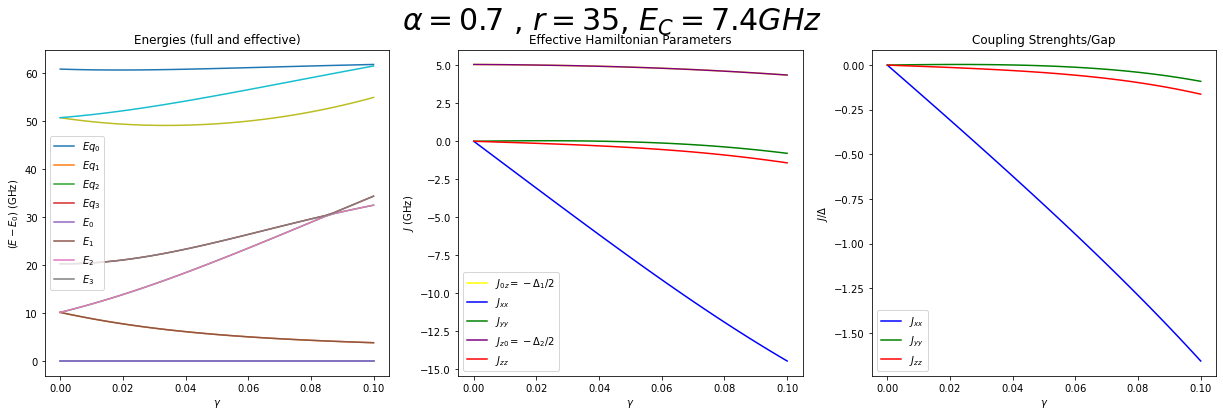

In [23]:
#Plot the results: full system and effective energies, effective Hamiltonian parameters and  effective -hamiltonian constanst/gap.
fig, (ax1, ax2, ax3)= plt.subplots(ncols=3, nrows=1, figsize=(21, 6))
fig.suptitle('$α=0.7$ , $r=35$, $E_C=7.4 GHz$', fontsize=30)

#Energies
ax1.plot(γ50, Eq50 - Eq50[:, 4*[0]], γ50, E50-E50[:,7*[0]], label='Inline label')
ax1.legend(('$Eq_0$','$Eq_1$','$Eq_2$','$Eq_3$','$E_0$','$E_1$','$E_2$','$E_3$'))
ax1.set_xlabel('$\gamma$')
ax1.set_ylabel('$(E-E_0)$ (GHz)') 
ax1.set_title('Energies (full and effective)')

#Constants.
colors=[['gray', 'gray', 'gray', 'yellow'],['gray', 'blue', 'gray', 'gray'],['gray', 'gray', 'green', 'gray'],['purple', 'gray', 'gray', 'red']]
labels = [['$J_{00}$', '$J_{0x}$','$J_{0y}=-\epsilon_1/2$','$J_{0z}=-\Delta_1/2$'],['$J_{x0}$', '$J_{xx}$','$J_{xy}$','$J_{xz}$'],['$J_{y0}=-\epsilon_2/2$', '$J_{yx}$','$J_{yy}$','$J_{yz}$'], ['$J_{z0}=-\Delta_2/2$', '$J_{zx}$','$J_{zy}$','$J_{zz}$']] # useful to print the legend.
for l in range(4):
    for n in range(4):
        if n!=0 or l!=0:
            if np.any(P50[:,l,n]!=0):
                label=labels[l][n]
                ax2.plot(γ50, P50[:,l,n],label = label, c=colors[l][n])
ax2.legend()
ax2.set_xlabel('$\gamma$')
ax2.set_ylabel('$J$ (GHz)') 
ax2.set_title('Effective Hamiltonian Parameters')

#Ratios.
for l in range(4):
    for n in range(4):
        if n!=0 and l!=0:
            if np.any(P50[:,l,n]!=0):
                label=labels[l][n]
                ax3.plot(γ50, P50[:,l,n]/(2*P50[:,0,3]),label = label, c = colors[l][n])
ax3.legend()
ax3.set_xlabel('$\gamma$')
ax3.set_ylabel('$J/\Delta$') 
ax3.set_title('Coupling Strenghts/Gap')

In [24]:
#Circuit parameters.
#Set parameters.
flux1=0.5*2*np.pi
flux2=0.5*2*np.pi
EJ=261.1
nmax=15
n0=10
rd=10
e=1e-4
β=0
α=0.7
EC=EJ/35
#γ given by the .txt.

#Load the results.
γ60, E60, Eq60, P60 = txt_to_npz(EJ, EC, α, β, nmax, 5) #The last parameter gives the coupling (r=4-> jj+capacitive coupling)

Text(0.5, 1.0, 'Coupling Strenghts/Gap')

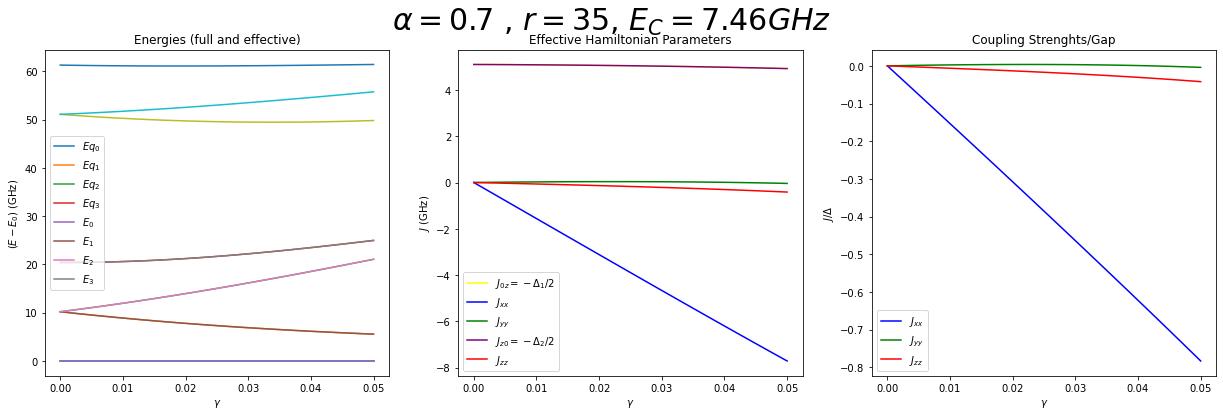

In [25]:
#Plot the results: full system and effective energies, effective Hamiltonian parameters and  effective -hamiltonian constanst/gap.
fig, (ax1, ax2, ax3)= plt.subplots(ncols=3, nrows=1, figsize=(21, 6))
fig.suptitle('$α=0.7$ , $r=35$, $E_C=7.46 GHz$', fontsize=30)

#Energies
ax1.plot(γ60, Eq60 - Eq60[:, 4*[0]], γ60, E60-E60[:,7*[0]], label='Inline label')
ax1.legend(('$Eq_0$','$Eq_1$','$Eq_2$','$Eq_3$','$E_0$','$E_1$','$E_2$','$E_3$'))
ax1.set_xlabel('$\gamma$')
ax1.set_ylabel('$(E-E_0)$ (GHz)') 
ax1.set_title('Energies (full and effective)')

#Constants.
colors=[['gray', 'gray', 'gray', 'yellow'],['gray', 'blue', 'gray', 'gray'],['gray', 'gray', 'green', 'gray'],['purple', 'gray', 'gray', 'red']]
labels = [['$J_{00}$', '$J_{0x}$','$J_{0y}=-\epsilon_1/2$','$J_{0z}=-\Delta_1/2$'],['$J_{x0}$', '$J_{xx}$','$J_{xy}$','$J_{xz}$'],['$J_{y0}=-\epsilon_2/2$', '$J_{yx}$','$J_{yy}$','$J_{yz}$'], ['$J_{z0}=-\Delta_2/2$', '$J_{zx}$','$J_{zy}$','$J_{zz}$']] # useful to print the legend.
for l in range(4):
    for n in range(4):
        if n!=0 or l!=0:
            if np.any(P60[:,l,n]!=0):
                label=labels[l][n]
                ax2.plot(γ60, P60[:,l,n],label = label, c=colors[l][n])
ax2.legend()
ax2.set_xlabel('$\gamma$')
ax2.set_ylabel('$J$ (GHz)') 
ax2.set_title('Effective Hamiltonian Parameters')

#Ratios.
for l in range(4):
    for n in range(4):
        if n!=0 and l!=0:
            if np.any(P60[:,l,n]!=0):
                label=labels[l][n]
                ax3.plot(γ60, P60[:,l,n]/(2*P60[:,0,3]),label = label, c = colors[l][n])
ax3.legend()
ax3.set_xlabel('$\gamma$')
ax3.set_ylabel('$J/\Delta$') 
ax3.set_title('Coupling Strenghts/Gap')

---
### Paper Graphics.

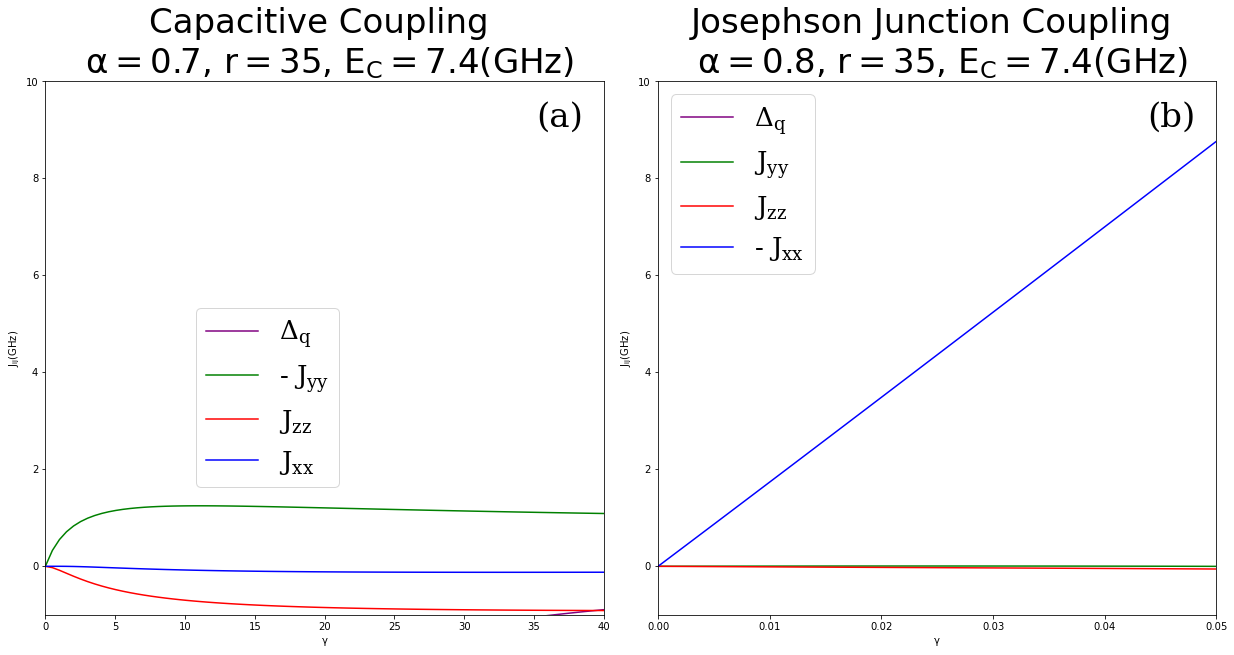

In [26]:
#Plot.
#Plot the results: effective Hamiltonian constants ratio, summary plots.
fig,(ax1, ax2)=plt.subplots(ncols=2, nrows=1, figsize=(17, 8.9), constrained_layout=True)
lines=['-','--','-.',':','-', '--', '-.',':']
colors=['blue','green','red']

SMALLER_SIZE = 12
SMALL_SIZE = 23
MEDIUM_SIZE = 23
BIGGER_SIZE = 30
ENORMOUS_SIZE = 34

#plt.rc('text', usetex=True)
plt.rc('font', family='serif')          # controls default text sizes
plt.rc('axes', titlesize=ENORMOUS_SIZE)     # fontsize of the title
plt.rc('axes', labelsize=ENORMOUS_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize


ax1.plot(γ20[:], -P20[:,0,3]*2, c='purple', label='$\mathdefault{\Delta_q}$')
ax1.plot(γ20[:], -P20[:,2,2], c=colors[1], label='- $\mathdefault{J_{yy}}$')
ax1.plot(γ20[:], P20[:,3,3], c=colors[2], label='$\mathdefault{J_{zz}}$')
ax1.plot(γ20[:], P20[:,1,1], c=colors[0], label='$\mathdefault{J_{xx}}$')
ax1.legend()
ax1.set_xlim([0,40])
ax1.set_ylim([-1,10])
ax1.set_xlabel('$\mathdefault{\gamma}$')
ax1.set_ylabel('$\mathdefault{J_{ij}}$(GHz)') 
ax1.set_title('Capacitive Coupling \n $\mathdefault{α=0.7}$, $\mathdefault{r=35}$, $\mathdefault{E_C=7.4}$(GHz)')
ax1.legend(bbox_to_anchor=(0.55, 0.6, 0, 0), fontsize=26)

ax2.plot(γ5[:], -P5[:,0,3]*2, c='purple', label='$\mathdefault{\Delta_q}$')
ax2.plot(γ5[:], P5[:,2,2], c=colors[1], label='$\mathdefault{J_{yy}}$')
ax2.plot(γ5[:], P5[:,3,3], c=colors[2], label='$\mathdefault{J_{zz}}$')
ax2.plot(γ5[:], -P5[:,1,1], c=colors[0], label='- $\mathdefault{J_{xx}}$')
ax2.legend()
ax2.set_xlabel('$\mathdefault{\gamma}$')
ax2.set_ylabel('$\mathdefault{J_{ij}}$(GHz)') 
ax2.set_title('Josephson Junction Coupling \n $\mathdefault{α=0.8}$, $\mathdefault{r=35}$, $\mathdefault{E_C=7.4}$(GHz)')
ax2.set_xlim([0,0.05])
ax2.set_ylim([-1,10])
ax2.legend(fontsize=26)

setlabel(ax1, '(a)', loc=1, borderpad=0.6, fontsize=34)
setlabel(ax2, '(b)', loc=1, borderpad=0.6, fontsize=34)


export('Realistic_parameters.pdf')